# The spelled-out intro to language modeling: building makemore

Following: https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

In [1]:
from pathlib import Path
from collections import defaultdict

In [2]:
data = Path('../data')

# Exploring bigrams (0:00 - 0:15:00)

Tasks done in the video:
- Load the dataset
- Explore
    - min/max length of names
    - number of names
- count all the bigrams into a dictionary
    - dedicated \<S\> and \<E\> tokens

In [3]:
names = (data/'names.txt').open().read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(names)

32033

In [5]:
min(len(name) for name in names), max(len(name) for name in names)

(2, 15)

In [6]:
bigrams = defaultdict(int)
start = '<S>'
end = '<E>'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        bigrams[(ch1,ch2)] += 1

In [7]:
sorted((bigram_tuples for bigram_tuples in bigrams.items()), key=lambda b: b[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

# Bigrams into torch.Tensor ( - 00:36:00, skipping efficiency until 00:50:00)

- Goal: n*n matrix that holds the bigram count in each cell
- No more dedicated start/stopping tokens, instead use . for both
- sample from the model
    - start with the starting dot
    - choose random next character according to probabilities in that row (torch.multinomial)
    - repeat until ending-dot is reached
    - Use torch.Generator for comparability

### Bigrams to Tensor

Extracting all used characters:

In [8]:
characters = set('.')
characters = characters.union(set(''.join(names)))
characters

{'.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [9]:
import torch

In [10]:
stoi = {char: i for i,char in enumerate(characters)}
itos = {i: char for char,i in stoi.items()}
stoi

{'i': 0,
 'h': 1,
 'r': 2,
 'm': 3,
 'c': 4,
 'f': 5,
 'p': 6,
 'e': 7,
 's': 8,
 'k': 9,
 't': 10,
 'j': 11,
 'z': 12,
 'g': 13,
 'o': 14,
 'n': 15,
 'x': 16,
 'd': 17,
 'q': 18,
 'b': 19,
 'w': 20,
 'l': 21,
 'a': 22,
 'u': 23,
 '.': 24,
 'v': 25,
 'y': 26}

In [11]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        bigrams[row_index, col_index] += 1

### Sampling

Counts for characters following the start character:

In [12]:
bigrams[stoi[start],:]

tensor([ 591.,  874., 1639., 2538., 1542.,  417.,  515., 1531., 2055., 2963.,
        1308., 2422.,  929.,  669.,  394., 1146.,  134., 1690.,   92., 1306.,
         307., 1572., 4410.,   78.,    0.,  376.,  535.])

Drawing a sample with counts as weights:

In [13]:
next_idx = torch.multinomial(bigrams[stoi[start],:], 1, replacement=True).item()
next_char = itos[next_idx]
next_char

'm'

Repeat until the stopping token is drawn:

In [14]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(bigrams[stoi[name[-1]],:], 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.n.
.dim.
.ahudan.
.n.
.lyle.
.roana.
.moaremianave.
.ykaltiarian.
.eneses.
.kengea.
.na.
.joxtety.
.kaizri.
.ifrexy.
.monnama.
.kaleslazaieererin.
.tnanei.
.w.
.ahanll.
.lavisynt.


Sanity-Check: Drawing with uniform probability

In [15]:
g = torch.Generator().manual_seed(2147483647)
weights = torch.ones(len(characters))

for i in range(20):
    name = start
    while True:
        next_idx = torch.multinomial(weights, 1, replacement=True, generator=g).item()
        next_char = itos[next_idx]
        name += next_char

        if next_char == end:
            break


    print(name)

.dabhhv.
.rdqdgvdulyokaholjnwctacscidonvgwycldjhwcfwjxptcekeazftpjqbdzuokqessyuzlikcm.
.imfjgylmtotnfnataqeedqtqimprshrjbzxnjmi.
.w.
.urxgjollb.
.ceypf.
.sudxzcxcouyajv.
.bdtpnqddxp.
.bwujpnlpsaupsgblvvnwamaadxpmrvctmnlsjhtjsdooxdggzzhnqcdviebyxuiyzektkohoeyyllzbvadqlplhuhabcrouazgqvxaeqbpexbseoguhpdgbtcarsoeankke.
.sjuczwqcjuoheyvjodaizpbwcdkeaomcnkcfwbljecximpxtb.
.fdtmbgtuelyfbiunpzpt.
.pzvzerfextcxnacwuiczyvbdwqrs.
.smcofkllgi.
.wvbzprghrnhhovtxntlltpzmbhlmdmewtgzydwrhkba.
.qwelxjxxke.
.lcftcybqndfkenal.
.gawitz.
.pnzjnymkiwjsckajckph.
.mfazxjwjuual.
.zvgwuvzexyhluca.


# Loss function ( - 01:03:00)

- negative Likelihood is used to measure loss (product of probabilities)
- use logs for numerical purposes (turns into the sum)

In [16]:
P = bigrams / bigrams.sum(dim=1, keepdim=True)

In [17]:
for name in names[:2]:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., e): -3.0408453941345215
(e, m): -3.2793259620666504
(m, m): -3.6772043704986572
(m, a): -0.9417552351951599
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 12.568990707397461
Mean Neg. Log-Likelihood: 2.513798236846924

(., o): -4.3981709480285645
(o, l): -2.550807476043701
(l, i): -1.7277942895889282
(i, v): -4.186665058135986
(v, i): -1.0382850170135498
(i, a): -1.9795759916305542
(a, .): -1.6298604011535645
Neg. Log-Likelihood: 17.511159896850586
Mean Neg. Log-Likelihood: 2.501594305038452



In [18]:
for name in ['andrej']:
    name = [start] + list(name) + [end]
    log_likelihood = 0
    n = 0
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        prob = P[row_index, col_index]
        log = torch.log(prob)
        log_likelihood += log
        n += 1
        
        print(f'({ch1}, {ch2}): {log}')
    print(f'Neg. Log-Likelihood: {-log_likelihood}')
    print(f'Mean Neg. Log-Likelihood: {-log_likelihood / n}')
    print('')

(., a): -1.9828919172286987
(a, n): -1.8295611143112183
(n, d): -3.259352207183838
(d, r): -2.562042474746704
(r, e): -2.012739896774292
(e, j): -5.917083740234375
(j, .): -3.7097861766815186
Neg. Log-Likelihood: 21.273456573486328
Mean Neg. Log-Likelihood: 3.03906512260437



# Neural Network Approach ( - 01:25:00)

- create training set
    - x tensor with first letter
    - y tensor with second letter
- use one-hot encoding to feed indices into nn
- "nn" is for now just a weight matrix and bias vector with grads
- output should be 27 dimensional
    - turn into "probabilities" by softmax
    

In [19]:
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names[:1]:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [20]:
g = torch.Generator().manual_seed(2147483647)

W = torch.rand(size=(27,27), requires_grad=True, generator=g)
b = torch.rand(size=(1,27), requires_grad=True, generator=g)

In [21]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0.]])

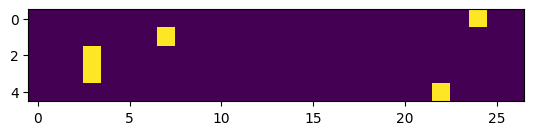

In [22]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

In [23]:
# xenc: 5 x 27
# W: 27 x 27
# xenc @ W: 5 x 27
# b: 1 x 27

output = xenc@W + b
output.shape

torch.Size([5, 27])

In [24]:
counts = output.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

probs[0,:]

tensor([0.0263, 0.0560, 0.0405, 0.0175, 0.0695, 0.0318, 0.0170, 0.0261, 0.0201,
        0.0264, 0.0339, 0.0359, 0.0390, 0.0248, 0.0483, 0.0357, 0.0899, 0.0286,
        0.0161, 0.0216, 0.0313, 0.0469, 0.0581, 0.0455, 0.0310, 0.0204, 0.0619],
       grad_fn=<SliceBackward0>)

In [25]:
F.softmax(output, dim=1)[0,:]

tensor([0.0263, 0.0560, 0.0405, 0.0175, 0.0695, 0.0318, 0.0170, 0.0261, 0.0201,
        0.0264, 0.0339, 0.0359, 0.0390, 0.0248, 0.0483, 0.0357, 0.0899, 0.0286,
        0.0161, 0.0216, 0.0313, 0.0469, 0.0581, 0.0455, 0.0310, 0.0204, 0.0619],
       grad_fn=<SliceBackward0>)

# Training loop ( - 01:47:00)

- get loss by taking nn-prob of actual next character
    - should be high --> neg. --> should be low
    - .log().mean()
- backward pass (set gradients to None)
- learning rate of 50 for now
- run training loop over all xs for now

In [26]:
# nn evaluation

xenc = F.one_hot(xs, num_classes=27).float()

output = xenc@W + b
probs = F.softmax(output, dim=1)

# actual next characters for each x in xs is in ys
predictions = probs[torch.arange(len(ys)), ys]
loss = predictions.log().mean()
loss

tensor(-3.3897, grad_fn=<MeanBackward0>)

In [27]:
# build training set with all data
bigrams = torch.zeros((len(characters), len(characters)))
start = '.'
end = '.'
xs = []
ys = []

for name in names:
    name = [start] + list(name) + [end]
    for ch1,ch2 in zip(name, name[1:]):
        row_index = stoi[ch1]
        col_index = stoi[ch2]
        xs.append(row_index)
        ys.append(col_index)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [28]:
# initialize nn
n_epochs = 100
lr = 50

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    output = xenc@W
    probs = F.softmax(output, dim=1)

    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    print(loss.item())

3.3260011672973633
3.076158285140991
2.9282710552215576
2.836986541748047
2.773505210876465
2.7272822856903076
2.6925697326660156
2.6656956672668457
2.644299268722534
2.6268491744995117
2.612330198287964
2.600050449371338
2.589521884918213
2.5803892612457275
2.5723886489868164
2.565319538116455
2.5590262413024902
2.553387403488159
2.548304557800293
2.5436999797821045
2.5395090579986572
2.535677433013916
2.5321617126464844
2.528923988342285
2.525932788848877
2.5231611728668213
2.520585536956787
2.518186569213867
2.51594614982605
2.513849973678589
2.5118837356567383
2.5100371837615967
2.508298635482788
2.506659746170044
2.5051121711730957
2.503648042678833
2.5022616386413574
2.5009467601776123
2.4996981620788574
2.4985108375549316
2.497380495071411
2.4963033199310303
2.4952757358551025
2.4942941665649414
2.4933559894561768
2.492457628250122
2.491598129272461
2.4907736778259277
2.489982843399048
2.4892234802246094
2.4884936809539795
2.4877917766571045
2.487116575241089
2.4864659309387207


# Notes ( - end)

- matrix multiply with one-hot encoded vector is the same as row-lookup (does indexing work with autograd?)
- fake-counts is the same as regularization
    -  + (W**2).mean()

In [29]:
# initialize nn
n_epochs = 100
lr = 50

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs,:]
    probs = F.softmax(output, dim=1)


    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    print(loss.item())

3.3260011672973633
3.076160430908203
2.928269863128662
2.8369860649108887
2.773505210876465
2.7272825241088867
2.6925694942474365
2.6656954288482666
2.644299268722534
2.6268489360809326
2.612330198287964
2.600050449371338
2.589521884918213
2.5803890228271484
2.5723884105682373
2.565319299697876
2.559026002883911
2.55338716506958
2.548304557800293
2.5436999797821045
2.539508581161499
2.535677194595337
2.5321617126464844
2.528923988342285
2.525932788848877
2.523160934448242
2.520585298538208
2.518186330795288
2.51594614982605
2.513849973678589
2.5118842124938965
2.5100371837615967
2.508298635482788
2.506659984588623
2.5051119327545166
2.503648042678833
2.5022616386413574
2.5009467601776123
2.4996981620788574
2.4985108375549316
2.497380495071411
2.4963033199310303
2.4952754974365234
2.4942941665649414
2.493356227874756
2.492457628250122
2.491598129272461
2.4907736778259277
2.489982843399048
2.4892234802246094
2.4884936809539795
2.4877917766571045
2.487116575241089
2.4864659309387207
2.485

In [30]:
# initialize nn
n_epochs = 100
lr = 50
l2 = .01

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(27,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs,:]
    probs = F.softmax(output, dim=1)


    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean() + l2 * (W**2).mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad
    

    with torch.no_grad():
        # loss without regularization term
        loss = -predictions.log().mean()
        print(loss.item())

3.3260011672973633
3.0760786533355713
2.9283394813537598
2.8372349739074707
2.773928642272949
2.7278571128845215
2.693270444869995
2.6665027141571045
2.6451985836029053
2.627829074859619
2.6133830547332764
2.6011693477630615
2.5907013416290283
2.5816245079040527
2.573676586151123
2.5666561126708984
2.5604095458984375
2.554814338684082
2.5497734546661377
2.5452089309692383
2.541055679321289
2.5372602939605713
2.5337793827056885
2.5305752754211426
2.527616024017334
2.5248749256134033
2.522329092025757
2.51995849609375
2.5177457332611084
2.5156757831573486
2.513735055923462
2.5119128227233887
2.510197877883911
2.5085818767547607
2.50705623626709
2.5056138038635254
2.5042479038238525
2.502952814102173
2.501723051071167
2.5005545616149902
2.4994425773620605
2.498382806777954
2.4973719120025635
2.4964072704315186
2.495485305786133
2.494602680206299
2.4937584400177
2.4929487705230713
2.4921724796295166
2.491427421569824
2.4907114505767822
2.490023374557495
2.48936128616333
2.4887239933013916


# Exercises

## #1 [Trigram Model] + #4 [Direct Indexing]

In [31]:
# build training set
start = ['.']
end = ['.']

xs = []
ys = []

for name in names:
    name = 2*start + list(name) + end
    for ch1,ch2,ch3 in zip(name, name[1:], name[2:]):
        #print(f'({ch1}{ch2}: {ch3}')
        xs.append([stoi[ch1], 27+stoi[ch2]])
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [32]:
xs[:5], ys[:5]

(tensor([[24, 51],
         [24, 34],
         [ 7, 30],
         [ 3, 30],
         [ 3, 49]]),
 tensor([ 7,  3,  3, 22, 24]))

In [33]:
# initialize nn
n_epochs = 1000
lr = 100
l2 = .0

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(54,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs].sum(dim=1)
    probs = F.softmax(output, dim=1)

    # loss
    predictions = probs[torch.arange(len(ys)), ys]
    loss = -predictions.log().mean() + l2 * (W**2).mean()

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad, 
    

    if epoch%50==0:
        print(epoch, loss.item())

    if epoch%300==0:
        lr /= 10

TypeError: unsupported operand type(s) for -=: 'Tensor' and 'tuple'

In [ ]:
# sampling

for _ in range(10):
    name = '..'
    while True:
        ch1 = stoi[name[-2]]
        ch2 = stoi[name[-1]]

        logits = W[[ch1, ch2]].sum(dim=0)
        probs = F.softmax(logits, dim=0)

        next = torch.multinomial(probs, 1, replacement=True)
        next_char = itos[next.item()]
        name = name + next_char

        if next_char=='.':
            break

    print(name)

..aadyd.
..az.
..asmdzetpsiquri.
..uaiuxmers.
..eln.
..ae.
..aaaen.
..azqebarcoe.
..oe.
..aelesiely.


## #2 Train/Dev/Test split + #3 Find regularization hyper-parameter

In [34]:
train_id = int(len(xs) * .8)
dev_id = int(len(xs) * .9)

x_train = xs[:train_id]
y_train = ys[:train_id]

x_dev = xs[:dev_id]
y_dev = ys[:dev_id]

x_test = xs[dev_id:]
y_test = ys[dev_id:]

print("Training size: ", len(x_train))
print("Dev size: ", len(x_dev))
print("Test size: ", len(x_test))

Training size:  182516
Dev size:  205331
Test size:  22815


In [44]:
# initialize nn
n_epochs = 30
lr = 10
l2 = .0

l2s = []
train_losses = []
dev_losses = []

for l2 in torch.logspace(-3, 1, 10):
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand(size=(54,27), requires_grad=True, generator=g)

    for epoch in range(n_epochs):
        # forward pass
        output = W[x_train].sum(dim=1)
        
        # loss
        loss = F.cross_entropy(output, y_train) + l2 * (W**2).mean()

        # backward pass
        W.grad = None

        loss.backward()

        # update
        with torch.no_grad():
            W -= lr * W.grad
        

    l2s.append(l2)
    with torch.no_grad():
        output = W[x_train].sum(dim=1)
        loss = F.cross_entropy(output, y_train)

    train_losses.append(loss.item())
    print('Train: ', l2.item(), loss.item())

    with torch.no_grad():
        output = W[x_dev].sum(dim=1)
        loss = F.cross_entropy(output, y_dev)

    dev_losses.append(loss.item())
    print('Test: ', l2.item(), loss.item())
    print('')

Train:  0.0010000000474974513 2.5225231647491455
Test:  0.0010000000474974513 2.5402915477752686

Train:  0.0027825594879686832 2.5225701332092285
Test:  0.0027825594879686832 2.5403354167938232

Train:  0.00774263683706522 2.522700309753418
Test:  0.00774263683706522 2.540456533432007

Train:  0.02154434658586979 2.523064613342285
Test:  0.02154434658586979 2.5407960414886475

Train:  0.059948425740003586 2.524095058441162
Test:  0.059948425740003586 2.5417582988739014

Train:  0.1668100506067276 2.5270824432373047
Test:  0.1668100506067276 2.5445587635040283

Train:  0.46415889263153076 2.5362088680267334
Test:  0.46415889263153076 2.5531909465789795

Train:  1.2915496826171875 2.565863609313965
Test:  1.2915496826171875 2.581629753112793

Train:  3.59381365776062 2.6560311317443848
Test:  3.59381365776062 2.669215440750122

Train:  10.0 2.841096878051758
Test:  10.0 2.8500518798828125



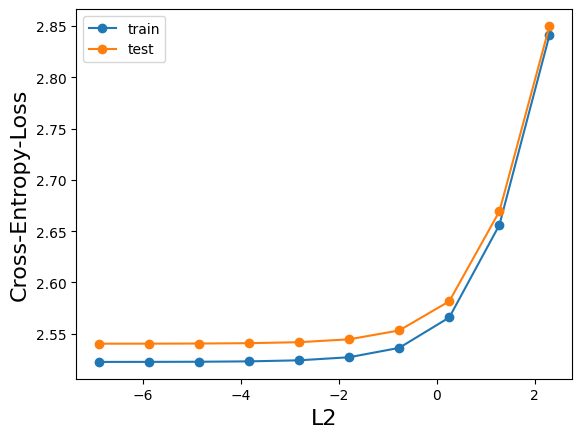

In [49]:
l2s = torch.tensor(l2s).log()

fig, ax = plt.subplots()

ax.plot(l2s, train_losses, marker='o', label='train')
ax.plot(l2s, dev_losses, marker='o', label='test')

ax.set_xlabel('L2', fontsize=16)
ax.set_ylabel('Cross-Entropy-Loss', fontsize=16)

ax.legend()

plt.show()

## #5 Cross entropy

In [ ]:
# initialize nn
n_epochs = 100
lr = 10
l2 = .0

g = torch.Generator().manual_seed(2147483647)
W = torch.rand(size=(54,27), requires_grad=True, generator=g)

for epoch in range(n_epochs):
    # forward pass
    output = W[xs].sum(dim=1)
    
    # loss
    loss = F.cross_entropy(output, ys)

    # backward pass
    W.grad = None

    loss.backward()

    # update
    with torch.no_grad():
        W -= lr * W.grad 
    

    print(epoch, loss.item())

0 3.3666110038757324
1 3.2446835041046143
2 3.143585205078125
3 3.0627737045288086
4 2.9977450370788574
5 2.943715810775757
6 2.8979060649871826
7 2.8587231636047363
8 2.824977159500122
9 2.795686960220337
10 2.7700514793395996
11 2.747429370880127
12 2.727311849594116
13 2.7092955112457275
14 2.6930556297302246
15 2.6783318519592285
16 2.6649117469787598
17 2.6526215076446533
18 2.64131760597229
19 2.630880117416382
20 2.6212074756622314
21 2.6122164726257324
22 2.6038339138031006
23 2.5959970951080322
24 2.5886528491973877
25 2.581754207611084
26 2.5752601623535156
27 2.5691349506378174
28 2.5633463859558105
29 2.5578672885894775
30 2.5526723861694336
31 2.547738552093506
32 2.543046474456787
33 2.5385775566101074
34 2.534316301345825
35 2.530247926712036
36 2.5263586044311523
37 2.522636890411377
38 2.519071578979492
39 2.5156524181365967
40 2.5123701095581055
41 2.5092170238494873
42 2.5061848163604736
43 2.5032663345336914
44 2.500455379486084
45 2.4977457523345947
46 2.4951317310